# You Only Look Once (YOLO)

Este componente utiliza o modelo YOLO para classificação usando [Yolov4](https://pypi.org/project/yolov4/). <br>
Está é uma biblioteca que encapsula o modelo yolov4 com algumas variações, podendo utilizar o modelo completo, como também,a versão reduzida.

## Declaração de parâmetros e hiperparâmetros

Declare parâmetros com o botão  na barra de ferramentas.<br>
A variável `dataset` possui o caminho para leitura do arquivos importados na tarefa de "Upload de dados".<br>
Você também pode importar arquivos com o botão  na barra de ferramentas.

Para esse componente, a base de dados deve estar no seguinte formado:
- Arquivo CSV chamado dataset.csv contendo as colunas "image_path", "target" e "subset", entre outras, caso necessário. Onde:
    - image_path: caminho para o arquivo de imagem.
    - target: resposta esperada da predição, caso exista.
    - subset: conjunto ao qual a amostra faz parte, pode ser "train", "test", e "val". 
- Imagens coloridas (3 canais)
- Cada conjunto de treino, validação e teste possuem sua pasta com suas respectivas imagens. Um exemplo da árvore de diretórios pode ser observado abaixo:

```bash
dataset
|________dataset.csv
|________train
|        |__________image0.jpg
|        |__________image1.jpg
|        |__________image2.jpg
|        |__________image3.jpg
|               ...
|
|________val
|        |__________image4.jpg
|        |__________image5.jpg
|        |__________image6.jpg
|        |__________image7.jpg
|               ...
|
|________test
|        |__________image8.jpg
|        |__________image9.jpg
|        |__________image10.jpg
|        |__________image11.jpg
|              ...
```

In [1]:
dataset = "/tmp/data/face_detection-14.zip" #@param {type:"string"}
image_path = "image_path" #@param {type:"string", label:"Caminho das imagens", description:"Coluna da tabela com o caminho para as imagens."}
language = "português" #@param ["português","inglês","espanhol"] {type:"string",multiple:false,label:"Idioma",description:"Linguagem a ser utilizada como descrição dos objetos identificados."}
score_threshold = 0.25 #@param {type:"number",label:"Score Threshold", description:"Limiar que seleciona apenas as predições que possuam probabilidade superior à este valor."}
iou_threshold = 0.30 #@param {type:"number", label:"IOU Threshold", description:"Dado os bbox produzidos a paritr do Score Threshold, este limiar que seleciona apenas as predições em uma união de bbox que possua probabilidade superior à este valor."}
yolo_weight_type = "tiny" #@param ["tiny","full"] {type:"string",multiple:false,label:"Pesos Pré-treinados",description:"Versão de pesos do YOLOv4 pré-treinado. Tiny é um modelo mais leve, full é o modelo completo."}

## Extração dos dados do arquivo .zip

In [2]:
# Model inference parameters
inference_parameters = {
    'score_threshold':score_threshold,
    'iou_threshold':iou_threshold,
    'language':language,
    'yolo_weight_type': yolo_weight_type
}

In [3]:
# Construct dataset folder name for unzipped files
folder = '.'.join(dataset.split('.')[:-1])

# Creating empty folder
!mkdir -p {folder}

# Extracting files
!unzip -o {dataset} -d {folder}

Archive:  /tmp/data/face_detection-14.zip
  inflating: /tmp/data/face_detection-14/dataset.csv  
  inflating: /tmp/data/face_detection-14/test/person-001.jpg  
  inflating: /tmp/data/face_detection-14/test/people-002.png  
  inflating: /tmp/data/face_detection-14/test/crowd-001.jpg  
  inflating: /tmp/data/face_detection-14/test/mask-001.jpg  
  inflating: /tmp/data/face_detection-14/test/mask-002.png  
  inflating: /tmp/data/face_detection-14/test/person-002.png  
  inflating: /tmp/data/face_detection-14/test/dog-002.png  
  inflating: /tmp/data/face_detection-14/test/cat-001.jpg  
  inflating: /tmp/data/face_detection-14/test/crowd-002.png  
  inflating: /tmp/data/face_detection-14/test/people-001.jpg  
  inflating: /tmp/data/face_detection-14/test/cat-002.png  
  inflating: /tmp/data/face_detection-14/test/dog-001.jpg  


In [4]:
import pandas as pd

# Read images path dataset
df = pd.read_csv(folder + '/dataset.csv')
df[image_path] = folder + df[image_path]

# Get all images paths for predicting
X = df[image_path].values

In [5]:
X

array(['/tmp/data/face_detection-14/test/person-001.jpg',
       '/tmp/data/face_detection-14/test/person-002.png',
       '/tmp/data/face_detection-14/test/dog-001.jpg',
       '/tmp/data/face_detection-14/test/dog-002.png',
       '/tmp/data/face_detection-14/test/people-001.jpg',
       '/tmp/data/face_detection-14/test/people-002.png',
       '/tmp/data/face_detection-14/test/cat-001.jpg',
       '/tmp/data/face_detection-14/test/cat-002.png',
       '/tmp/data/face_detection-14/test/crowd-001.jpg',
       '/tmp/data/face_detection-14/test/crowd-002.png',
       '/tmp/data/face_detection-14/test/mask-001.jpg',
       '/tmp/data/face_detection-14/test/mask-002.png'], dtype=object)

## Classificação das imagens

In [6]:
import numpy as np
import cv2
import tensorflow as tf
from PIL import Image

In [7]:
# Download YOLO weights
import gdown

if yolo_weight_type == 'tiny':
    gdown.download('https://drive.google.com/u/0/uc?id=1GJwGiR7rizY_19c_czuLN8p31BwkhWY5', 'yolov4-tiny.weights', quiet=False)

elif yolo_weight_type == 'full': 
    gdown.download('https://drive.google.com/uc?id=1L-SO373Udc9tPz5yLkgti5IAXFboVhUt', 'yolov4-full.weights', quiet=False)
    
else:
    print(f'[ERROR] Not implemented with \'{yolo_weight_type}\', using \'full\' as default.')
    gdown.download('https://drive.google.com/uc?id=1L-SO373Udc9tPz5yLkgti5IAXFboVhUt', 'yolov4-full.weights', quiet=False)

Downloading...
From: https://drive.google.com/u/0/uc?id=1GJwGiR7rizY_19c_czuLN8p31BwkhWY5
To: /home/jovyan/tasks/YOLO (Lucas)/yolov4-tiny.weights
24.3MB [00:02, 10.0MB/s]


In [7]:
# Read and format classes list
names_list = None
names = {}

if language == 'português':
    file = open('cocopt.names', 'r')
    names_list = file.read().split('\n')
    
elif language == 'inglês':
    file = open('coco.names', 'r')
    names_list = file.read().split('\n')

elif language == 'espanhol':
    file = open('cocoes.names', 'r')
    names_list = file.read().split('\n')
    
else: # Default fallback
    print(f'[ERROR] Not implemented with \'{language}\', using \'inglês\' as default.')
    file = open('coco.names', 'r')
    names_list = file.read().split('\n')
    
for i, name in enumerate(names_list):
    names[i] = name

In [8]:
from yolov4.tf import YOLOv4

# Load the model
is_tiny = yolo_weight_type == 'tiny'
yolo = YOLOv4(tiny=is_tiny)

# Configure classes
yolo.classes = "coco.names"

# Load weights
yolo.make_model()

if yolo_weight_type == 'tiny':
    yolo.load_weights("yolov4-tiny.weights", weights_type="yolo")
else:
    yolo.load_weights("yolov4-full.weights", weights_type="yolo")

Call tf.config.experimental.set_memory_growth(GPU0, True)


In [9]:
# Classify images
from yolo_utils import decode_yolo_bbox

results = {}
yolo_raw = {}

result_id = 0
for img in X:
    
    ext = img.split('.')[-1].lower()
    
    if ext in ['jpg', 'jpeg', 'png']:
    
        frame = np.array(Image.open(img))
        
        # prediction (x, y, w, h, class, prob)
        predictions = yolo.predict(frame, 
                                   score_threshold=inference_parameters['score_threshold'], 
                                   iou_threshold=inference_parameters['iou_threshold'])
        
        yolo_raw[img] = predictions

        for prediction in predictions:
            
            # How to interpret YOLO bbox: https://stackoverflow.com/questions/52455429/what-does-the-coordinate-output-of-yolo-algorithm-represent
            encoded_bbox = prediction[:4]
            decoded_bbox = decode_yolo_bbox(frame, encoded_bbox)
            prob = prediction[-1]
            name = names[int(prediction[4])]
            
            results[result_id] = {'image': img, 'class': name, 'probability': prob, 'coords(x_min,y_min,x_max,y_max)': decoded_bbox}
            result_id += 1

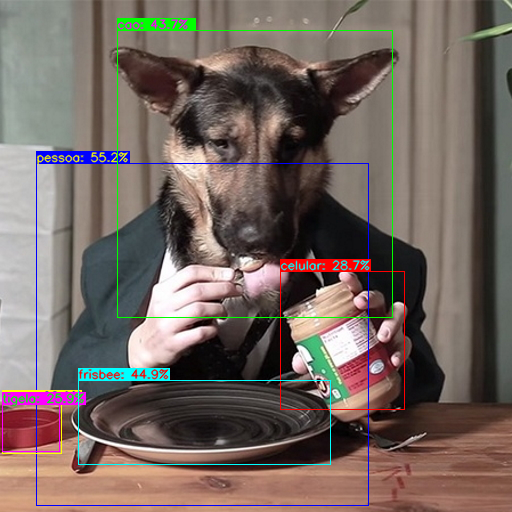

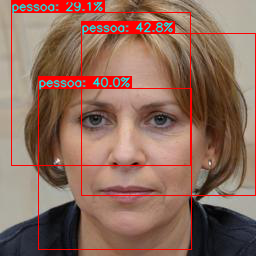

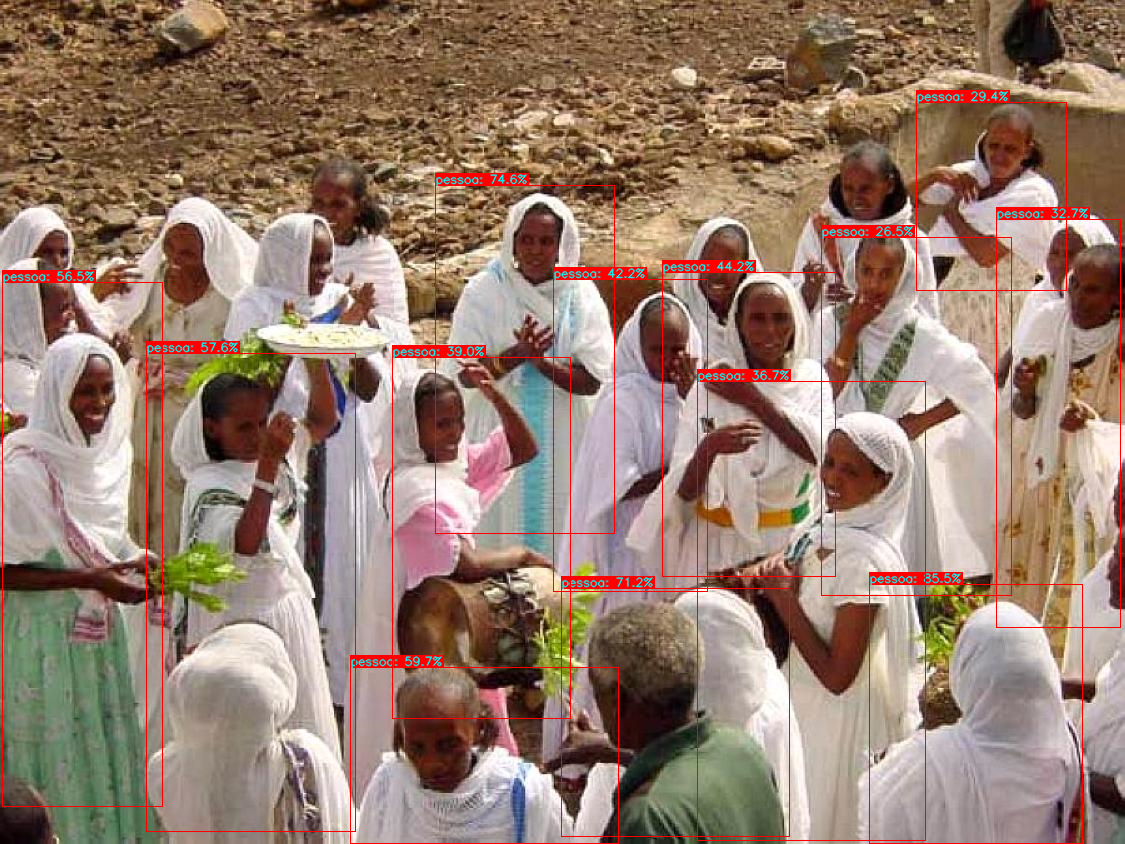

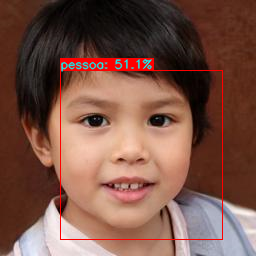

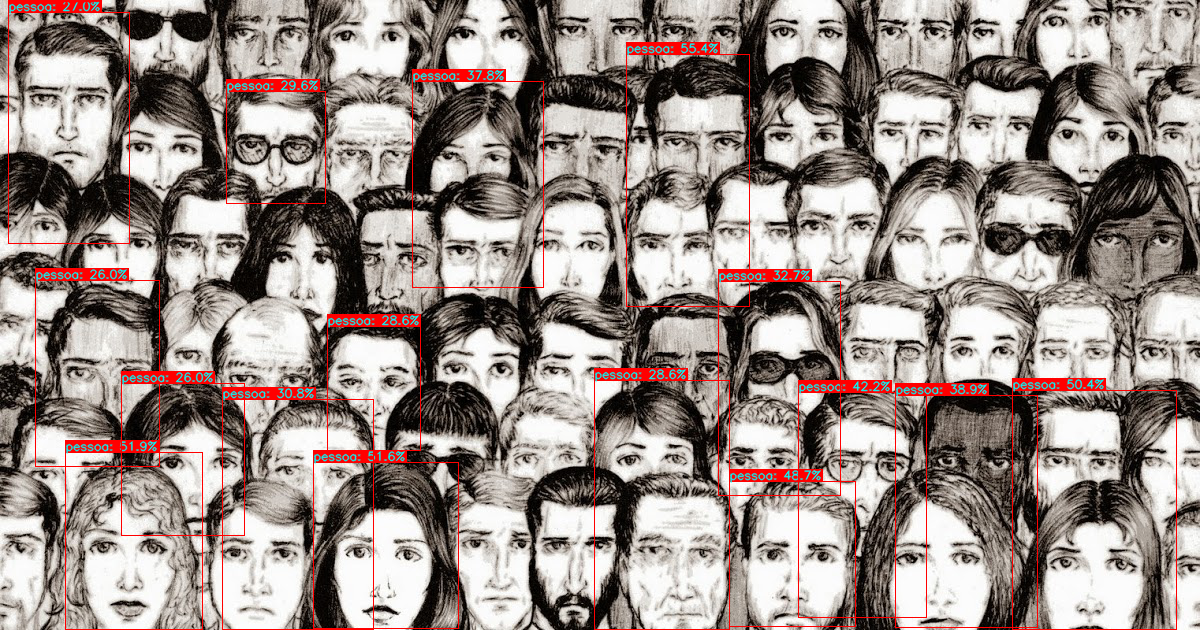

In [11]:
# Drawing sample results

from draws import draw_bboxes

# Compile results in DF
res_df = pd.DataFrame(results).T

# Select a sample of uniques to show results
uniques = np.random.choice(X,  min(len(X), 5), replace=False)

for unique in uniques:
    
    frame = np.array(Image.open(unique).convert('RGB'))
    
    unique_df = res_df[res_df['image'] == unique]
    bboxes = unique_df['coords(x_min,y_min,x_max,y_max)'].values
    probs = unique_df['probability'].values
    labels = unique_df['class'].values
    
    img = draw_bboxes(frame, bboxes, probs, labels)
    img = Image.fromarray(img)
    img.show()

In [ ]:
# # save dataset changes
# res_df.to_csv('/tmp/data/dataset.csv', index=False)

## Salva resultados da tarefa 

A plataforma guarda o conteúdo de `/tmp/data/` para as tarefas subsequentes.

In [13]:
from joblib import dump

artifacts = {
    "names": names,
    "inference_parameters": inference_parameters
}

dump(artifacts, "/tmp/data/yolo.joblib")

['/tmp/data/yolo.joblib']